In [1]:
%precision %g
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from math import sqrt, pi, sin, cos, floor, exp
import numpy as np
from numpy import linalg as LA
from scipy import constants as con
import matplotlib.pyplot as plt

In [2]:
tend = 1
N = 100
L = 1

def solver(tend, N, L=1, obstacle=None,rho=1,nu=0.1,P=10):
    """Will solve a 2-d channel flow system according
        to Navier-Stokes equations for an NxN grid in
        a channel of length L, height L/2, iterating
        for <tend> seconds"""

    """# physical parameters of fluid
    rho = 1        #density
    nu = 0.1       #viscosity
    P = 10         #constant term"""

    #solving parameters
    dt = 1e-3      # Time step
    epsilon = dt/1000

    a = 2*L / N #grid spacing

    #creates ball obstacle
    if obstacle == 'ball':
        x0,y0 = N/2,N/2     #origin
        r = 0.1*N      #radius
        xgrid,ygrid = np.ogrid[-x0:N-x0+1,-y0:N-y0+1]
        mask = xgrid**2 + ygrid**2 <= r**2
    elif obstacle == 'wing':
        x0,y0 = N/2,N/2      #y coordinate of wing center
        h = 8         #thickness of wing
        xgrid,ygrid = np.ogrid[-x0:N-x0,-y0:N-y0]
        mask = ygrid <= h

    t = 0.0
    #t1 = tend / 4
    #t2 = 2*tend/4
    #t3 = 3*tend/4
    #t4 = tend
    tend += epsilon

    #initial conditions for velocity and pressure
    u = np.zeros([N+1,N+1],float) #x velocity
    up = np.zeros([N+1,N+1],float)

    v = np.zeros([N+1,N+1],float) #y velocity
    vp = np.zeros([N+1,N+1],float)

    p = P*np.ones([N+1,N+1],float) #pressure (scalar)
    pp = P*np.ones([N+1,N+1],float)

    #b = np.zeros((ny, nx))

    while t < tend:

        """boundary conditions at walls"""
        u[0,:] = 0.0 #at y = 0
        v[0,:] = 0.0
        u[-1,:] = 0.0 #at y = L/2
        v[-1,:] = 0.0

        """boundary conditions at obstacle surface"""
        if obstacle != None:
            #velocities in object's interior = 0
            u[mask] = 0.0
            v[mask] = 0.0
            #p[mask] = 0.0

            if obstacle == 'ball':
                #pressure in object's interior = 0
                pass
                #derivative of pressure at object boundary = 0

            elif obstacle == 'wing':
                #pressure in object's interior = 0
                pass
                #derivative of pressure at object boundary = 0


        """SOLVES DIFFERENTIAL EQUATIONS"""

        """Pressure"""
        for k in range(N+1):
            #boundary condition for x = 0
            pp[1:-1, 0] = ((p[1:-1,1] + p[1:-1,-1]
                          + p[2:,0] + p[0:-2,0]) / 4
                          - a**2 / 2)
                          #* b[1:-1, 0])

            #pressure on the interior of the region
            pp[1:-1, 1:-1] = ((p[1:-1,2:] + p[1:-1,0:-2]
                             + p[2:,1:-1] + p[0:-2,1:-1]) / 4
                             - a**2 / 2)
                             #* b[1:-1, 1:-1])

            #boundary condition for x = L
            pp[1:-1, -1] = ((p[1:-1,0] + p[1:-1,-2]
                           + p[2:,-1] + p[0:-2,-1]) / 4
                           - a**2 / 2)
                           #* b[1:-1, -1])

            #boundary conditions on upper/lower wall
            #derivative of pressure = 0 at top/bottom walls
            p[-1, :] = p[-2, :]
            p[0, :] = p[1, :]

            #switches arrays storing each
            p, pp = pp, p

        """Velocity"""
        #step = u[1:-1, 2:] + u[1:-1, 0:-2] + u[2:, 1:-1] + u[0:-2, 1:-1] - 4 * u[1:-1, 1:-1]
        up[1:-1, 1:-1] = (u[1:-1, 1:-1]
                            - u[1:-1, 1:-1] * dt / a
                            * (u[1:-1, 1:-1] - u[1:-1, 0:-2])
                            - v[1:-1, 1:-1] * dt / a
                            * (u[1:-1, 1:-1] - u[0:-2, 1:-1])
                            - dt / (2 * rho * a)
                            * (p[1:-1, 2:] - p[1:-1, 0:-2])
                            + nu * dt / a**2
                            * (u[1:-1, 2:] + u[1:-1, 0:-2]
                               + u[2:, 1:-1] + u[0:-2, 1:-1]
                               - 4 * u[1:-1, 1:-1])
                            + P * dt)

        vp[1:-1, 1:-1] = (v[1:-1, 1:-1]
                            - u[1:-1, 1:-1] * dt / a
                            * (v[1:-1, 1:-1] - v[1:-1, 0:-2])
                            - v[1:-1, 1:-1] * dt / a
                            * (v[1:-1, 1:-1] - v[0:-2, 1:-1])
                            - dt / (2 * rho * a)
                            * (p[2:, 1:-1] - p[0:-2, 1:-1])
                            + nu * dt / a**2
                            * (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, 0:-2]
                            + v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[0:-2, 1:-1]))

        """Velocity boundary conditions"""
        #for x = 0
        up[1:-1, 0] = (u[1:-1, 0] - u[1:-1, 0] * dt / a
                    * (u[1:-1, 0] - u[1:-1, -1])
                    - v[1:-1, 0] * dt / a
                    * (u[1:-1, 0] - u[0:-2, 0])
                    - dt / (2 * rho * a)
                    * (p[1:-1, 1] - p[1:-1, -1])
                    + nu * dt / a**2
                    * (u[1:-1, 1] - 2 * u[1:-1, 0] + u[1:-1, -1]
                    + u[2:, 0] - 2 * u[1:-1, 0] + u[0:-2, 0])
                    + P * dt)

        #for x = 0
        vp[1:-1, 0] = (v[1:-1, 0] - u[1:-1, 0] * dt / a
                    * (v[1:-1, 0] - v[1:-1, -1])
                    - v[1:-1, 0] * dt / a
                    * (v[1:-1, 0] - v[0:-2, 0])
                    - dt / (2 * rho * a)
                    * (p[2:, 0] - p[0:-2, 0])
                    + nu * dt / a**2
                    * (v[1:-1, 1] - 2 * v[1:-1, 0] + v[1:-1, -1]
                    + v[2:, 0] - 2 * v[1:-1, 0] + v[0:-2, 0]))

        #for x = L
        up[1:-1, -1] = (u[1:-1, -1] - u[1:-1, -1] * dt / a
                     * (u[1:-1, -1] - u[1:-1, -2])
                     - v[1:-1, -1] * dt / a
                     * (u[1:-1, -1] - u[0:-2, -1])
                     - dt / (2 * rho * a)
                     * (p[1:-1, 0] - p[1:-1, -2])
                     + nu * dt / a**2
                     * (u[1:-1, 0] - 2 * u[1:-1,-1] + u[1:-1, -2]
                     + u[2:, -1] - 2 * u[1:-1, -1] + u[0:-2, -1])
                     + P * dt)

        #for x = L
        vp[1:-1, -1] = (v[1:-1, -1] - u[1:-1, -1] * dt / a
                     * (v[1:-1, -1] - v[1:-1, -2])
                     - v[1:-1, -1] * dt / a
                     * (v[1:-1, -1] - v[0:-2, -1])
                     - dt / (2 * rho * a)
                     * (p[2:, -1] - p[0:-2, -1])
                     + nu * dt / a**2
                     * (v[1:-1, 0] - 2 * v[1:-1, -1] + v[1:-1, -2]
                     + v[2:, -1] - 2 * v[1:-1, -1] + v[0:-2, -1]))


        #switching arrays for velocity and pressure
        u, up = up, u
        v, vp = vp, v

        t += dt #advance time step

    return u, v, p

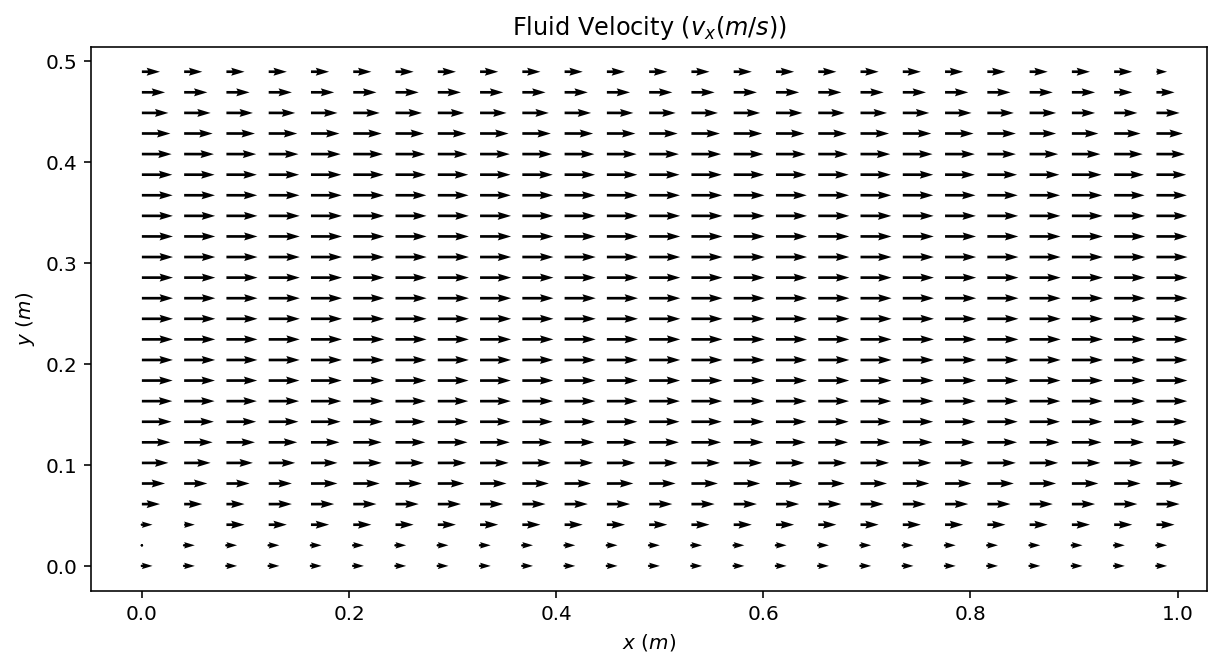

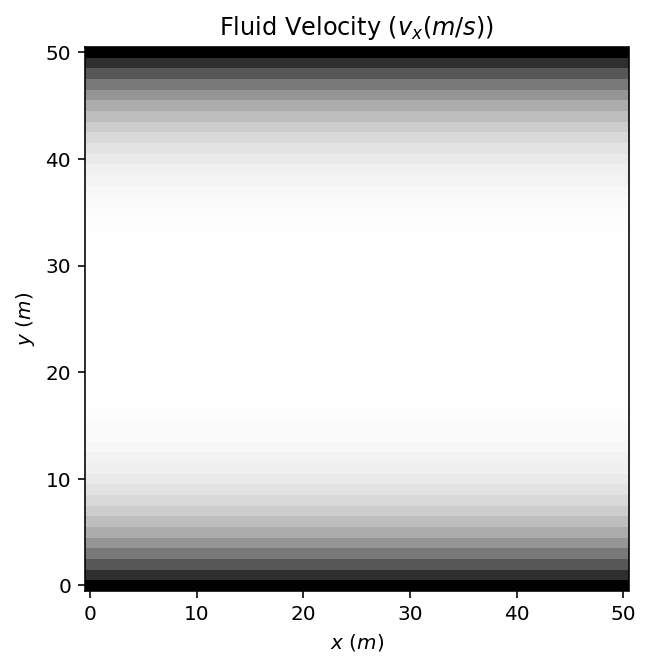

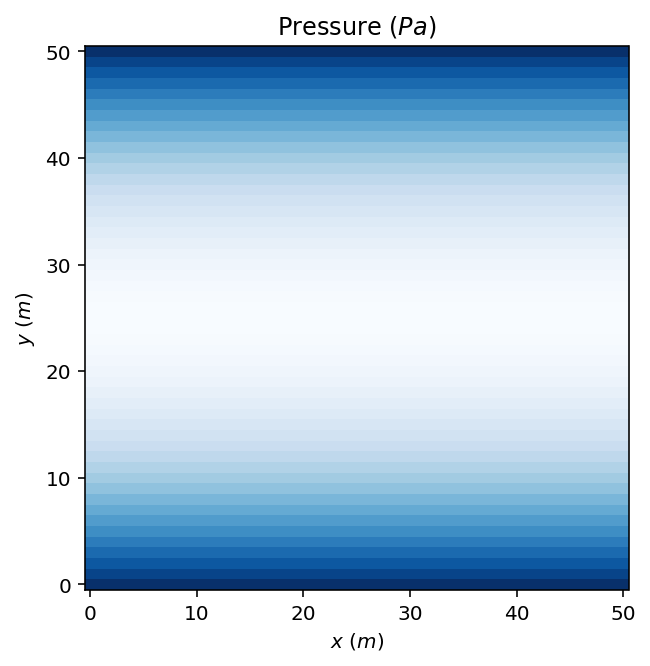

In [14]:
tend = 0.5
N = 50
L = 1

#initiates quiver plot
x = np.linspace(0, L, N)
y = np.linspace(0, L/2, N)
X, Y = np.meshgrid(x, y)

u1,v1,p1 = solver(tend,N,L)#,obstacle='ball')


fig1, ax1 = plt.subplots(1, 1, figsize = (10, 5))

a = 2 #frequency of arrows
ax1.quiver(X[::a, ::a], Y[::a, ::a], u1[::a, ::a], v1[::a, ::a])
ax1.set_title("Fluid Velocity ($v_x (m/s)$)")
ax1.set_xlabel("$x\ (m)$")
ax1.set_ylabel("$y\ (m)$")


fig2, ax2 = plt.subplots(1, 1, figsize = (10, 5))

ax2.imshow(u1,origin='lower',cmap='gray')
ax2.set_title("Fluid Velocity ($v_x (m/s)$)")
ax2.set_xlabel("$x\ (m)$")
ax2.set_ylabel("$y\ (m)$")


fig3, ax3 = plt.subplots(1, 1, figsize = (10, 5))

ax3.imshow(p1,origin='lower',cmap='Blues')
ax3.set_title("Pressure ($Pa$)")
ax3.set_xlabel("$x\ (m)$")
ax3.set_ylabel("$y\ (m)$")


In [19]:
#N=10
mask = np.zeros([N+1,N+1],dtype=bool)
mask[int(N/2):int(N/2)+3,int(N/6):int(2*N/3)] = True
mask[int(N/2)+3:int(N/2)+4,int(N/3):int(2*N/3)] = True
mask[int(N/2)+4:int(N/2)+5,int(N/2):int(2*N/3)] = True
#mask[int(N/2)+1,int(N/6):int(N/3)]
#mask[int(N/2)+2,int(N/3):int(N/2)]
for i in range(len(mask)):
    print(mask[i,:])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
[False False False False False False False False False False Fal